## Nonlinear Registration

In [1]:
%%time
# Standard Library Imports
import os

# Third Party Imports
import ants
import numpy as np
import tifffile
import matplotlib.pyplot as plt

# Local Imports
import clearex
from clearex.registration.common import import_affine_transform
from clearex.registration.linear import transform_image
import clearex.file_operations.tools as tools
from clearex.plot.images import mips
from tests import download_test_registration_data


CPU times: user 15.1 s, sys: 2.26 s, total: 17.4 s
Wall time: 15.4 s


## Specify Images and Directories

In [7]:
%%time
output_path = download_test_registration_data()


CPU times: user 704 ms, sys: 294 ms, total: 998 ms
Wall time: 53.2 s


KeyboardInterrupt: 

## Import Images

In [9]:
%%time
# Define file paths
fixed_path = os.path.join(
    output_path,
    "cropped_fixed.tif")

moving_path = os.path.join(
    output_path,
    "cropped_moving.tif")

transform_path = os.path.join(
    output_path,
    "GenericAffine.mat")

transform_list = [transform_path]


print(f"Loading fixed image: {fixed_path}")
fixed_roi = tifffile.imread(fixed_path)

print(f"Loading moving image: {moving_path}")
moving_roi = tifffile.imread(moving_path)
print("Image shape:", moving_roi.shape)

Loading fixed image: downloaded_data/cropped_fixed.tif
Loading moving image: downloaded_data/cropped_moving.tif
Image shape: (925, 163, 306)
CPU times: user 54.1 ms, sys: 96.2 ms, total: 150 ms
Wall time: 151 ms


## Import Affine Transform

In [10]:
%%time
print(f"Importing affine transform from: {transform_path}")
transform = import_affine_transform(transform_path)

Importing affine transform from: downloaded_data/GenericAffine.mat
CPU times: user 9.42 ms, sys: 1.85 ms, total: 11.3 ms
Wall time: 22.4 ms


## Apply Affine Transform to Moving Image

In [11]:
%%time
print("Applying transform to moving image...")
transformed_image = transform_image(moving_roi, fixed_roi, transform)

Applying transform to moving image...
CPU times: user 10.5 s, sys: 448 ms, total: 11 s
Wall time: 4.69 s


## Identify Smallest ROI that Encapsulates the Data

In [12]:
%%time
print("Identifying smallest ROI that encapsulates the data.")
print("The original data shape:", fixed_roi.shape)
fixed_roi, transformed_image, bounding_box = tools.crop_overlapping_datasets(
    fixed_roi,
    transformed_image,
    robust=True,
    lower_pct = 3,
    upper_pct = 97,
)
print(f"The cropped data shape: {fixed_roi.shape}")


Identifying smallest ROI that encapsulates the data.
The original data shape: (925, 163, 306)
The cropped data shape: (610, 136, 291)
CPU times: user 379 ms, sys: 124 ms, total: 503 ms
Wall time: 502 ms


## Plot MIPs of the Fixed and Transformed Images

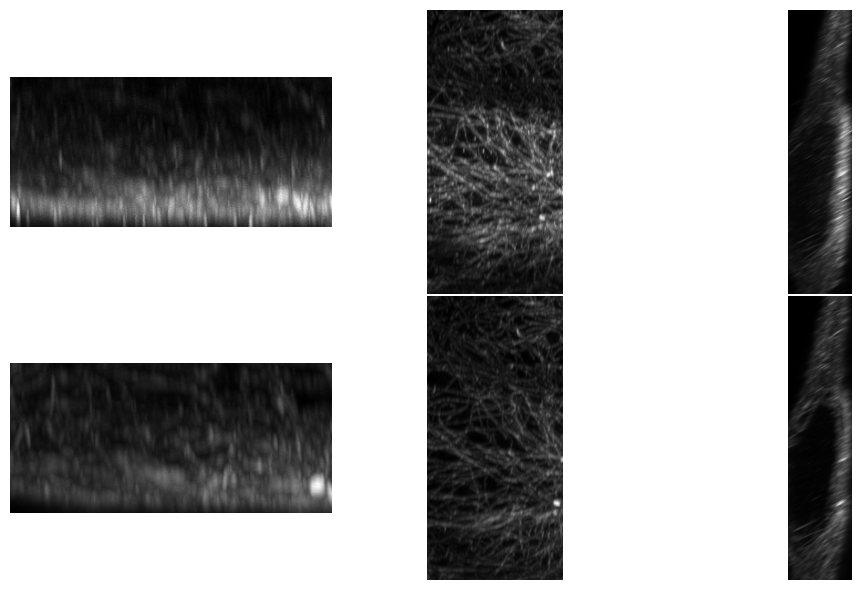

In [13]:
mips(fixed_roi, transformed_image)

## Nonlinear Registration

In [14]:
%%time
nonlinear_transformed, transform_path = clearex.registration.nonlinear.register_image(
        moving_image=moving_roi,
        fixed_image=fixed_roi,
        accuracy="high",
        verbose=True,
)

print("The nonlinear transform is located at :", transform_path)


antsRegistration --dimensionality 3 -r Identity --metric mattes[0x7f6721acd3c8,0x7f6721acfb68,1,32] --transform SyN[0.200000,3.000000,0.500000] --convergence [100x70,1e-7,8] --smoothing-sigmas 1x0 --shrink-factors 2x1 -u 0 -z 1 --output [/tmp/tmpq1wit8yd,0x7f6721acf2a8,0x7f6721acea88] -x [NA,NA] --float 0 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using double precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Identity (type = MatrixOffsetTransformBase)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 2
  fixed image: 0x7f6721acd3c8
  moving image: 0x7f6721acfb68
Dimension = 3
Number of stages = 1
Use histogram matching = false
Winsorize image intensities = false
  Lower quantile = 0
  Upper quantile = 1


Stage 1 State
   Image metric = MattesMI
     Fixed image = Image (0x555576002610)
  RTTI typeinfo:   itk::Image<double, 3u>
  Reference Count: 2
  Modified Tim

## Inspect Nonlinear Transformed Data

In [15]:
%%time
nonlinear_transformed

CPU times: user 0 ns, sys: 43 μs, total: 43 μs
Wall time: 97 μs


ANTsImage (RAI)
	 Pixel Type : unsigned int (uint32)
	 Components : 1
	 Dimensions : (610, 136, 291)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

## Apply Histogram Matching

In [16]:
%%time
print("Histogram matching the warped data to the original data.")
transformed_image = ants.from_numpy(transformed_image)

# Histogram match to original data.
warped_image = ants.histogram_match_image(
    source_image=nonlinear_transformed['warpedmovout'],
    reference_image=transformed_image
    # number_of_match_points=...
    # use_threshold_at_mean_intensity=...
)


Histogram matching the warped data to the original data.
CPU times: user 4.81 s, sys: 346 ms, total: 5.15 s
Wall time: 2.25 s


## Calculate and Plot Displacement Field

Calculating average displacement amplitude. 
Average displacement: 0.76 mm, Max displacement: 9.30 mm


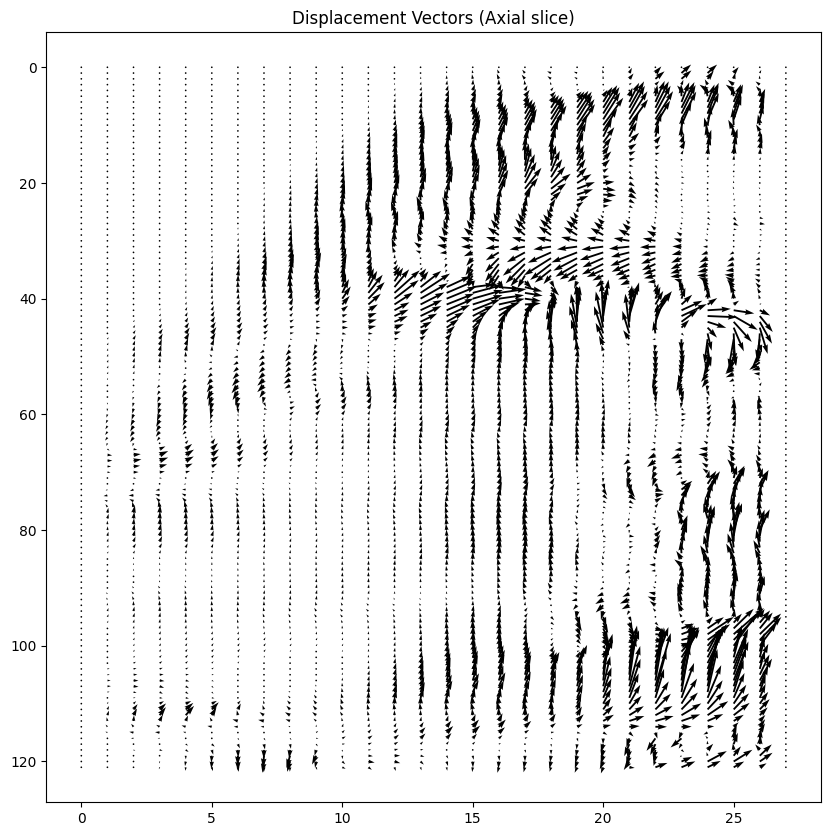

In [18]:
print("Calculating average displacement amplitude. ")
warp = ants.image_read(transform_path[0]).numpy()
mag = np.linalg.norm(warp, axis=-1)  # magnitude at each voxel
avg_disp = mag.mean()
max_disp = mag.max()
print(f"Average displacement: {avg_disp:.2f} mm, Max displacement: {max_disp:.2f} mm")

z = warp.shape[2] // 2  # middle axial slice
u = warp[:, :, z, 0]  # x-component
v = warp[:, :, z, 1]  # y-component

plt.figure(figsize=(10, 10))
plt.quiver(u[::5, ::5], v[::5, ::5])  # subsample for readability
plt.title("Displacement Vectors (Axial slice)")
plt.gca().invert_yaxis()
plt.show()